# Monte Carlo Nullpoint Approach - Code Description

This is the central code for looking at nullpoints under a Jupyter Notebooks framework

This is the python script for replicating the Bi,Spencer 2D stabilization technique with the intention of varying TI for Eq.3 to observe the TI related nullpoint - this code has the potential to look at a histogram for each TI value or to look at the standard deviation across the population for a range of TI values

# Import Libraries

In [25]:
#Preparing all libraries
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
from scipy.optimize import curve_fit
from scipy.linalg import svd
import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm

# Set Options

In [26]:
#Initial Options
histPlot = True
stdPlot = True

nullMethod = False      #As if we only have TI values around the first nullpoint
unknownT12 = False      #IF we don't know the T12 nullpoint - true if only one nullpoint is known

random_start = True

# Initialize Parameters and Arrays

In [27]:
#Assumed echo time points
TE_array = np.arange(8, 513, 8) #ms units
num_TI_nullpoint = 5
num_guess_nullpoint = 13
num_TI_conventional = 12
TI_array_conven = np.linspace(2,4,num_TI_conventional) 
TI_array_conven = 10**TI_array_conven #ms units
TI_array_np = np.linspace(2,4,num_TI_nullpoint) 
TI_array_np = 10**TI_array_np #ms units

aStart = 0.7
aEnd = 1.4
alpha_nullArray = np.linspace(aStart, aEnd, 5)

#This is the percent error we have around the actual nullpoint
#0 corresponds to perfect knowledge
randRad = 0.05
if random_start:
    num_starts = 10

#Parameters that dictate process related features
iterCount = 100 #number of iterations that curveFit is applied
SNR_nullpoint = 1000
SNR_conventional = SNR_nullpoint * ((num_guess_nullpoint + num_TI_nullpoint)/num_TI_conventional)**(1/2)

######All Fixed parameters for code
#Parameters held constant
c1 = 0.4
c2 = 0.6
T21 = 45
T22 = 100
T11 = 600
T12 = 1200

initParams = np.array([T11, T12, c1, c2, T21, T22])

#Bound used during NLLS to constrain the upper bound on T2 values
T1_bound = 1500
T2_bound = 300

#Zoom Fits range
rad = 0.05 #percent radius around the zoom fits

#Preparing TI array to loop through
TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

if nullMethod:
    TI_nullArray = TI1star*alpha_nullArray
    addPhrase = str('\nNullpoint TI Array - ' + r'$\alpha$'+ ' Array: (' + str(aStart) + '-' + str(aEnd)+')' + ' :: # Points = ' + str(np.size(TI_nullArray)))
else:
    TI_nullArray = TI_array_conven
    addPhrase = ""

#Initializing all the storage matrices
#Storing all strings associated with titles
paramTitle_np = ['c1', 'c2', 'T21', 'T22']
paramTitle_6p = ['T11','T12','c1','c2','T21','T22']
paramTitle_4p = ['c1','c2','T21','T22']

round_Params = [round(num, 2) for num in initParams]
pList = ', '.join(str(x) for x in round_Params)
pTitleList = ', '.join(x for x in paramTitle_6p) #Builds the list of parametes used to generate the original data

#Initializing where all parameter values are stored
paramStore_6p = np.zeros([iterCount, np.size(paramTitle_6p)]) #6 parameter fit to the mesh
paramStore_4p = np.zeros([iterCount, np.size(paramTitle_4p)]) #4 parameter fit to the mesh - TIs known
paramStore_np = np.zeros([iterCount, np.size(paramTitle_np)]) #one nullpoint known
paramStore_np2 = np.zeros([iterCount, np.size(paramTitle_np)]) #both nullpoints known

#Initialize an array to collect T12 parameter values - if only T11 is known and T12 is unknown
T12Store_np = np.zeros([iterCount])

#Storing all the estimated signals for each iteration and TI array
sigStore_6p = np.zeros([iterCount, np.size(TE_array), np.size(TI_array_conven)])
sigStore_4p = np.zeros([iterCount, np.size(TE_array), np.size(TI_array_np)])
sigStore_np = np.zeros([iterCount, np.size(TE_array), np.size(TI_nullArray)])

#All error related matrices
RSS_6p = np.zeros([iterCount])
RSS_4p = np.zeros([iterCount])
RSS_np = np.zeros([iterCount])
RSS_nps = np.zeros([iterCount])

#Time to Compute
ttC_6p = 0
ttC_4p = 0
ttC_np = 0

#Title String
details = str('\nTI1* = ' + str(round(TI1star,2)) + ' : TI2* = ' + str(round(TI2star,2)) +" :: SNR (6p) = " + str(SNR_conventional) + " :: SNR (5p) = " + str(SNR_nullpoint) + " :: Iter  = " + str(iterCount) +
            '\nParams (' + pTitleList + ') = ' + '('+ pList + ')' +
            '\nTE Range (' + str(TE_array[0]) + "," + str(TE_array[np.size(TE_array)-1]) +
            '):: # Points = ' + str(np.size(TE_array)) +
            '\nStandard TI Exp Range (' + str(np.log10(TI_array_conven[0])) + "," + str(np.log10(TI_array_conven[-1])) +
            '):: # 6p TI Points = ' + str(np.size(TI_array_conven))  + '# 5p TI Points = ' + str(np.size(TI_array_np)) + addPhrase)

# Define Functions

In [37]:
#Defining the function of interest
def S_biX_6p(TE, TI, T11, T12, c1, c2, T21, T22):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

#This is necessary for the curve_fit algorithm
def S_biX_6p_ravel(T_dat, T11, T12, c1, c2, T21, T22):
    TE, TI = T_dat
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

def S_biX_5p_ravel(T_dat, T11, c1, d2, T21, T22):
    TE, TI = T_dat
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

#Defining the monoExp function of interest
def S_moX_2p(TE, d, T2):
    return d*np.exp(-TE/T2)

def S_moX_3p(TE, TI, T1, c, T2):
    return c*(1-2*np.exp(-TI/T1))*np.exp(-TE/T2)

#Function for calculating the d coeficient for a TI, c, T1 collection
def d_value(TI,c,T1):
    return c*(1-2*np.exp(-TI/T1))

def add_noise(SNR,dat):
    noiseSigma = np.max(np.abs(dat))/SNR
    noise = np.random.normal(0,noiseSigma,dat.shape)
    return dat + noise

def Jacobian_6p(TE, TI, T11, T12, c1, c2, T21, T22):
    #Returns the Jacobian of our 6 parameter, 2D problem
    dc1 = (1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    dc2 = (1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    dT11 = (-2*c1*TI/T11**2)*np.exp(-(TI/T11 + TE/T21))
    dT12 = (-2*c2*TI/T12**2)*np.exp(-(TI/T12 + TE/T22))
    dT21 = (c1*TE/T21**2)*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    dT22 = (c2*TE/T22**2)*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    
    jacobian = np.stack((dc1, dc2, dT11, dT12, dT21, dT22), axis = -1)
    return jacobian

def Jacobian_4p(TE, d1, d2, T21, T22):
    #Returns the Jacobian of our 4 parameter, 2D problem
    dd1 = np.exp(-TE/T21)
    dd2 = np.exp(-TE/T22)
    dT21 = (d1*TE/T21**2)*np.exp(-TE/T21)
    dT22 = (d2*TE/T22**2)*np.exp(-TE/T22)
    
    jacobian = np.stack((dd1, dd2, dT21, dT22), axis = -1)
    return jacobian

def check_param_order(popt):
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[-1] < popt[-2]): #We want by convention to make sure that T21 is <= T22
        for pi in range(np.size(popt)//2):
            p_hold = popt[2*pi]
            popt[2*pi] = popt[2*pi+1]
            popt[2*pi+1] = p_hold
    return popt

def set_p0(lb, ub, positions = [], random = random_start, seed_val = 1):
    true_params = [T11, T12, c1, c2, T21, T22]
    for pos in positions:
        lb[pos] = (1-randRad)*true_params[pos]
        ub[pos] = (1+randRad)*true_params[pos]
    if random:
        # np.random.seed(seed_val)
        p0 = [np.random.uniform(lb[i],ub[i]) for i in range(len(lb))]
    else:
        p0 = true_params

    # p0 = check_param_order(p0)
            
    return p0

def estimate_NLLS(function, tdata, data, init_p, lb, ub):

    popt, pcov = curve_fit(function, tdata, data, bounds = (lb, ub), p0=init_p, maxfev = 4000)
    popt = check_param_order(popt)
        
    return popt

def multistart_estimate_NLLS(function, tdata, noisey_sig, lb, ub, known_params = [], starts = num_starts):
    best_RSS = np.inf
    best_params = [] 
    for start in range(starts):
        init_p = set_p0(lb, ub, positions = known_params, seed_val = start)
        hold_popt = estimate_NLLS(function, tdata, noisey_sig, init_p, lb, ub)
        recreated_curve = function(tdata, *hold_popt)
        recreated_curves_RSS = np.sum((noisey_sig - recreated_curve)**2)

        if recreated_curves_RSS < best_RSS:
            best_RSS = recreated_curves_RSS
            best_params = hold_popt
        
    return best_params, best_RSS

def get_hist_index(param_label):
    if param_label[-1] == '2':
        row = 1
    else:
        row = 0

    if param_label[:-1] == "T1":
        col = 0
    elif param_label[:-1] == "c":
        col = 1
    else:
        col = 2

    return row, col

def calc_MSE(paramStore, true_params, clipped = False):
    varMat = np.var(paramStore,axis=0)
    biMat = np.mean(paramStore,axis=0) - true_params
    MSEMat = varMat + biMat**2
    if clipped:
        return MSEMat[-4:], biMat[-4:], varMat[-4:]
    return MSEMat, biMat, varMat


In [29]:
def parameter_histogram(paramStore, true_params, labels, add_title):
    fig, ax = plt.subplots(2, 3, figsize=(12,5.5), tight_layout=True)
    fig.suptitle(add_title + details)

    MSEMat, _, _ = calc_MSE(paramStore, true_params)

    for ii in range(paramStore.shape[1]):

        row, col = get_hist_index(labels[ii])
        #Construct a nice figure of each of the two 
        ax[row, col].hist(x=paramStore[:,ii], bins=20, color='b', label = labels[ii], alpha = 0.7)
        ax[row, col].set_xlabel('Param Value')
        ax[row, col].set_ylabel('Count')
        ax[row, col].axvline(x=true_params[ii], linewidth=1, label= 'True ' + labels[ii], color='black')
        ax[row, col].axvline(x=np.mean(paramStore[:,ii]), linewidth=1, label= 'Avg ' + labels[ii], color='red', ls = "--")
        ax[row, col].legend()
        ax[row, col].set_title('True ' + labels[ii] + '=' + "{:.2e}".format(true_params[ii]) + 
                    # '\nVar(' + paramTitle_6p[2*ii] + ') = ' +"{:.2e}".format(varMat[2*ii]) + 
                    # '\nBias(' + paramTitle_6p[2*ii] + ') = ' + "{:.2e}".format(biMat[2*ii]) + 
                    '\nMSE(' + labels[ii] + ') = ' + "{:.2e}".format(MSEMat[ii]))
    plt.show()
    return

def statistic_bars(MSE, bias, var):

    biasSq = bias**2

    barWidth = 0.25
    fig, ax = plt.subplots(2,2, figsize =(12, 8), tight_layout=True)

    fig.suptitle(details)

    # Set position of bar on X axis
    br1 = np.arange(MSE.shape[1])
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]

    for ii in range(MSE.shape[1]):
        MSE_sample = MSE[:,ii]
        biasSq_sample = biasSq[:,ii]
        var_sample = var[:,ii]

        param_oi_name = paramTitle_4p[ii]
        # Make the plot
        ax[ii//2, ii%2].bar(br1, MSE_sample, color ='r', width = barWidth,
                edgecolor ='grey', label ='MSE')
        ax[ii//2, ii%2].bar(br2, biasSq_sample, color ='g', width = barWidth,
                edgecolor ='grey', label ='square bias')
        ax[ii//2, ii%2].bar(br3, var_sample, color ='b', width = barWidth,
                edgecolor ='grey', label ='var')

        # Adding Xticks
        ax[ii//2, ii%2].set_xlabel('Fit Method', fontweight ='bold', fontsize = 15)
        ax[ii//2, ii%2].set_ylabel('Value', fontweight ='bold', fontsize = 15)
        ax[ii//2, ii%2].set_xticks([r + barWidth for r in range(len(MSE_sample))],
                ['conven', 'T11 known', 'T12 known', 'both known'])
        ax[ii//2, ii%2].set_title('Fit Results for ' + param_oi_name)
        ax[ii//2, ii%2].legend()
    plt.show()
    return

# Random Start Subproject

### Generate Data

In [38]:
paramStore_6p_conven_random = np.zeros((iterCount,6))
paramStore_T11_known_random = np.zeros((iterCount,6))
paramStore_T12_known_random = np.zeros((iterCount,6))
paramStore_both_known_random = np.zeros((iterCount,6))

RSS_6p_conven = np.zeros(iterCount)
RSS_T11_known = np.zeros(iterCount)
RSS_T12_known = np.zeros(iterCount)
RSS_both_known = np.zeros(iterCount)

lb = [0,0,0,0,0,0]
ub = [T1_bound, T1_bound, 1, 1, T2_bound, T2_bound]

lb_np1 = [(1-randRad)*T11, 0, 0, 0, 0, 0]
ub_np1 = [(1+randRad)*T11, T1_bound, 1, 1, T2_bound, T2_bound]

lb_np2 = [0, (1-randRad)*T12, 0, 0, 0, 0]
ub_np2 = [T1_bound, (1+randRad)*T12, 1, 1, T2_bound, T2_bound]

for iter in trange(iterCount):
    mTE_c, mTI_c = np.meshgrid(TE_array,TI_array_conven)
    mS_c = S_biX_6p(mTE_c,mTI_c,*initParams)
    mS_noised_c = add_noise(SNR_conventional, mS_c)

    vecT_c = np.vstack((mTE_c.ravel(), mTI_c.ravel())) #flattens the data points
    vecS_c = mS_noised_c.ravel()

    mTE_np, mTI_np = np.meshgrid(TE_array,TI_array_conven)
    mS_np = S_biX_6p(mTE_np,mTI_np,*initParams)
    mS_noised_np = add_noise(SNR_nullpoint, mS_np)

    vecT_np = np.vstack((mTE_np.ravel(), mTI_np.ravel())) #flattens the data points
    vecS_np = mS_noised_np.ravel()

    #### Estimate parameters without any parameters known
    popt_6p_conven, RSS_hold = multistart_estimate_NLLS(S_biX_6p_ravel, vecT_c, vecS_c, lb, ub)
    paramStore_6p_conven_random[iter, :] = popt_6p_conven
    RSS_6p_conven[iter] = RSS_hold

    #### Estimate parameters with the T11 parameter known (through knowing the first null point)
    popt_T11_known, RSS_hold = multistart_estimate_NLLS(S_biX_6p_ravel, vecT_np, vecS_np, lb_np1, ub_np1)
    paramStore_T11_known_random[iter, :] = popt_T11_known
    RSS_T11_known[iter] = RSS_hold

    #### Estimate parameters with the T12 parameter known (through knowing the second null point)
    popt_T12_known, RSS_hold = multistart_estimate_NLLS(S_biX_6p_ravel, vecT_np, vecS_np, lb_np2, ub_np2)
    paramStore_T12_known_random[iter, :] = popt_T12_known
    RSS_T12_known[iter] = RSS_hold

    #### Estimate parameters with the T11 and T12 parameter known (through knowing both null points)
    # popt_both_known, RSS_hold = multistart_estimate_NLLS(S_biX_6p_ravel, vecT, vecS, lb, ub, known_params = [0,1])
    # paramStore_both_known_random[iter, :] = popt_both_known
    # RSS_both_known[iter] = RSS_hold
 

100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


### Plot Results

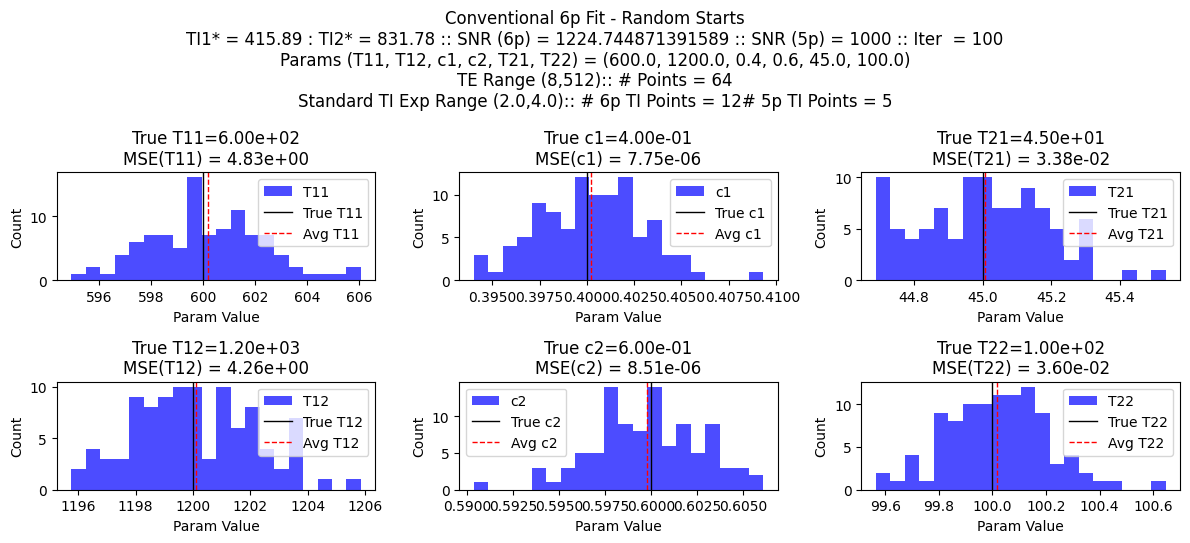

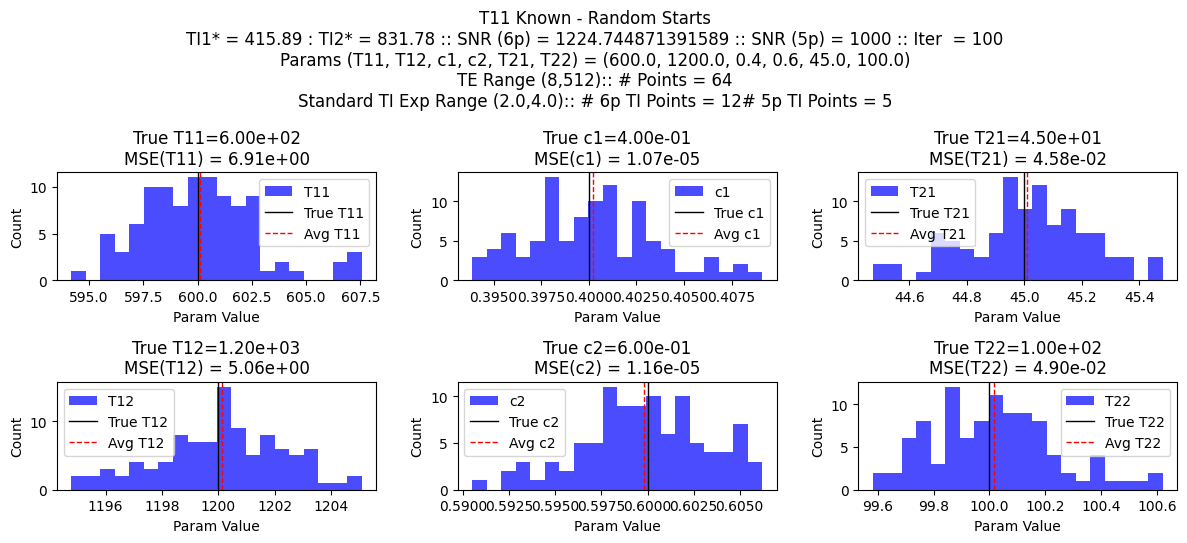

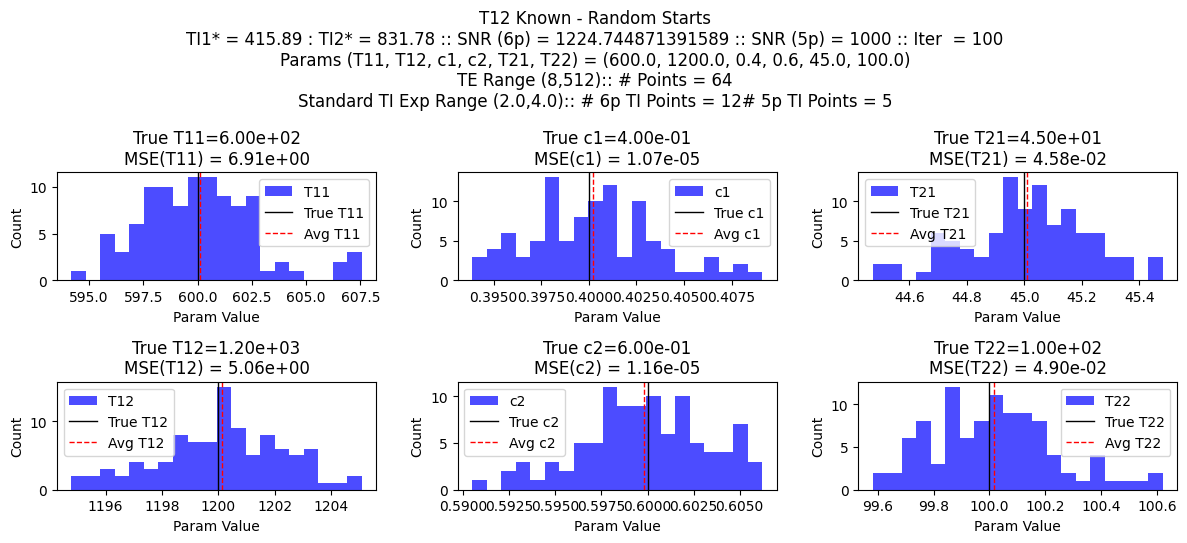

In [39]:
##### Plots Conventional Results
title_hold = "Conventional 6p Fit - Random Starts"
parameter_histogram(paramStore_6p_conven_random, initParams, paramTitle_6p, title_hold)

title_hold = "T11 Known - Random Starts"
parameter_histogram(paramStore_T11_known_random, initParams, paramTitle_6p, title_hold)

title_hold = "T12 Known - Random Starts"
parameter_histogram(paramStore_T12_known_random, initParams, paramTitle_6p, title_hold)

# title_hold = "T11 & T12 Known - Random Starts"
# parameter_histogram(paramStore_both_known_random, initParams, paramTitle_6p, title_hold)

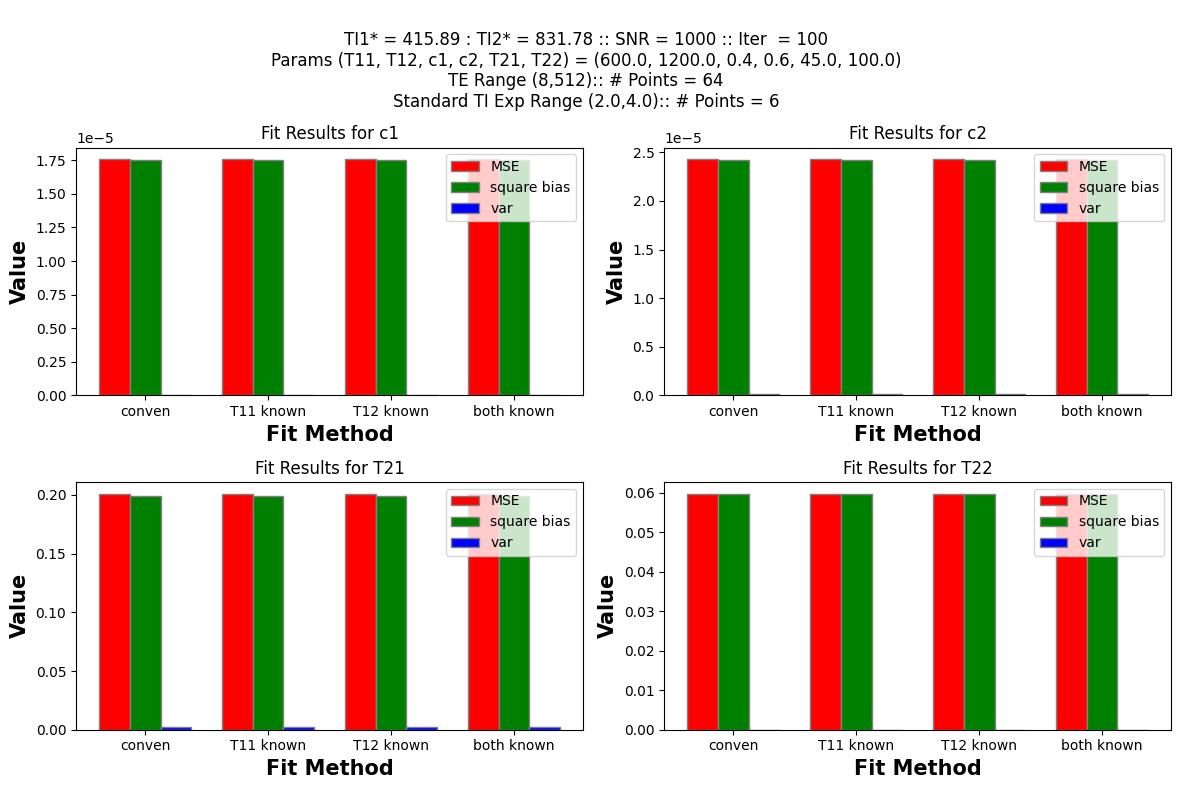

In [91]:
conven_MSE, conven_bias, conven_var = calc_MSE(paramStore_6p_conven_random, initParams, clipped = True)
T11_known_MSE, T11_known_bias, T11_known_var = calc_MSE(paramStore_T11_known_random, initParams, clipped = True)
T12_known_MSE, T12_known_bias, T12_known_var = calc_MSE(paramStore_T12_known_random, initParams, clipped = True)
both_known_MSE, both_known_bias, both_known_var = calc_MSE(paramStore_both_known_random, initParams, clipped = True)

MSE_complete = np.stack([conven_MSE, T11_known_MSE, T12_known_MSE, both_known_MSE])
bias_complete = np.stack([conven_bias, T11_known_bias, T12_known_bias, both_known_bias])
var_complete = np.stack([conven_var, T11_known_var, T12_known_var, both_known_var])

statistic_bars(MSE_complete, bias_complete, var_complete)


# Fixed Parameter Subproject Dataset

### Generate Data

In [43]:
paramStore_6p_conven = np.zeros((iterCount,6))
paramStore_T11_known = np.zeros((iterCount,5))
paramStore_T12_known = np.zeros((iterCount,5))
paramStore_both_known = np.zeros((iterCount,4))

for iter in trange(iterCount):
    mTE_c, mTI_c = np.meshgrid(TE_array,TI_array_conven)
    mS_c = S_biX_6p(mTE_c,mTI_c,*initParams)
    mS_noised_c = add_noise(SNR_conventional, mS_c)

    vecT_c = np.vstack((mTE_c.ravel(), mTI_c.ravel())) #flattens the data points
    vecS_c = mS_noised_c.ravel()

    mTE_np, mTI_np = np.meshgrid(TE_array,TI_array_conven)
    mS_np = S_biX_6p(mTE_np,mTI_np,*initParams)
    mS_noised_np = add_noise(SNR_nullpoint, mS_np)

    vecT_np = np.vstack((mTE_np.ravel(), mTI_np.ravel())) #flattens the data points
    vecS_np = mS_noised_np.ravel()


    #### Estimate parameters without any parameters known
    init_p = [T11, T12, c1, c2, T21, T22]
    lb = [0,0,0,0,0,0]
    ub = [T1_bound, T1_bound, 1, 1, T2_bound, T2_bound]

    popt_6p_conven, pcov_6p_conven = curve_fit(S_biX_6p_ravel, vecT_c, vecS_c, p0 = init_p, bounds = [lb,ub])

    popt_6p_conven = check_param_order(popt_6p_conven)

    paramStore_6p_conven[iter, :] = popt_6p_conven

    #### Estimate parameters with the T11 parameter known (through knowing the first null point)
    init_p = [T12, c1, c2, T21, T22]
    lb = [0,0,0,0,0]
    ub = [T1_bound, 1, 1, T2_bound, T2_bound]

    T11_assumed = T11#*np.random.uniform(1-randRad, 1+randRad)
    popt_T11_known, pcov_T11_known = curve_fit(lambda t_dat, e_T12, e_c1, e_c2, e_T21, e_T22 : 
                                    S_biX_6p_ravel(t_dat, T11_assumed, e_T12, e_c1, e_c2, e_T21, e_T22), 
                                    vecT_np, vecS_np, p0 = init_p, bounds = [lb,ub])

    popt_T11_known = check_param_order(popt_T11_known)

    paramStore_T11_known[iter, :] = popt_T11_known

    #### Estimate parameters with the T12 parameter known (through knowing the second null point)
    init_p = [T11, c1, c2, T21, T22]
    lb = [0,0,0,0,0]
    ub = [T1_bound, 1, 1, T2_bound, T2_bound]

    T12_assumed = T12#*np.random.uniform(1-randRad, 1+randRad)
    popt_T12_known, pcov_T12_known = curve_fit(lambda t_dat, e_T11, e_c1, e_c2, e_T21, e_T22 : 
                                    S_biX_6p_ravel(t_dat, e_T11, T12_assumed, e_c1, e_c2, e_T21, e_T22), 
                                    vecT_np, vecS_np, p0 = init_p, bounds = [lb,ub])

    popt_T12_known = check_param_order(popt_T12_known)

    paramStore_T12_known[iter, :] = popt_T12_known

    #### Estimate parameters with the T11 and T12 parameter known (through knowing both null points)
    init_p = [c1, c2, T21, T22]
    lb = [0,0,0,0]
    ub = [1, 1, T2_bound, T2_bound]

    T11_assumed = T11#*np.random.uniform(1-randRad, 1+randRad)
    T12_assumed = T12#*np.random.uniform(1-randRad, 1+randRad)
    popt_both_known, pcov_both_known = curve_fit(lambda t_dat, e_c1, e_c2, e_T21, e_T22 : 
                                    S_biX_6p_ravel(t_dat, T11_assumed, T12_assumed, e_c1, e_c2, e_T21, e_T22), 
                                    vecT_np, vecS_np, p0 = init_p, bounds = [lb,ub])

    popt_both_known = check_param_order(popt_both_known)

    paramStore_both_known[iter, :] = popt_both_known
 

100%|██████████| 100/100 [00:01<00:00, 57.92it/s]


### 2D Fitting Process Results

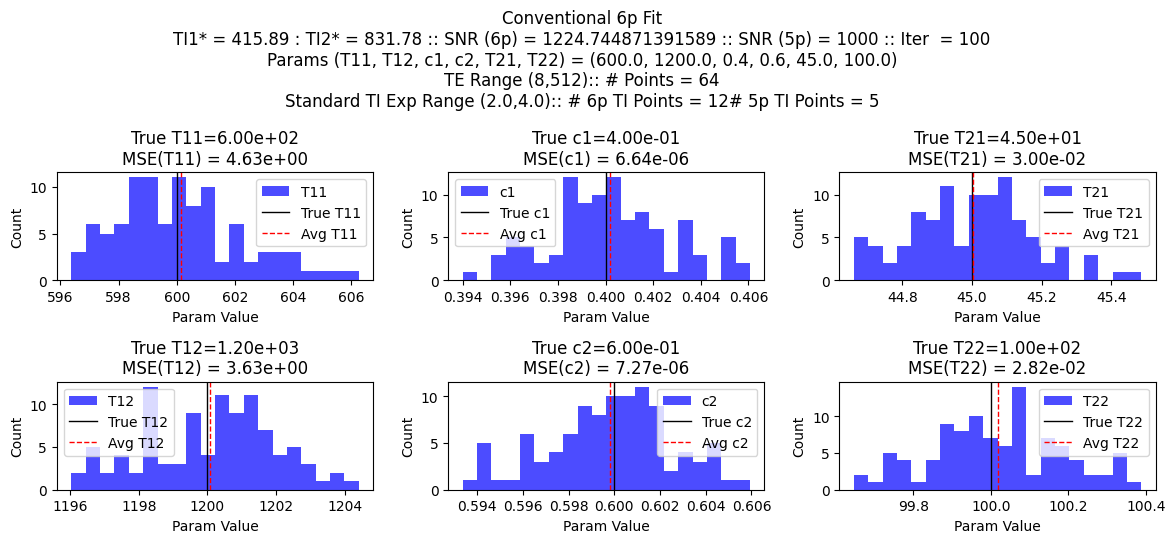

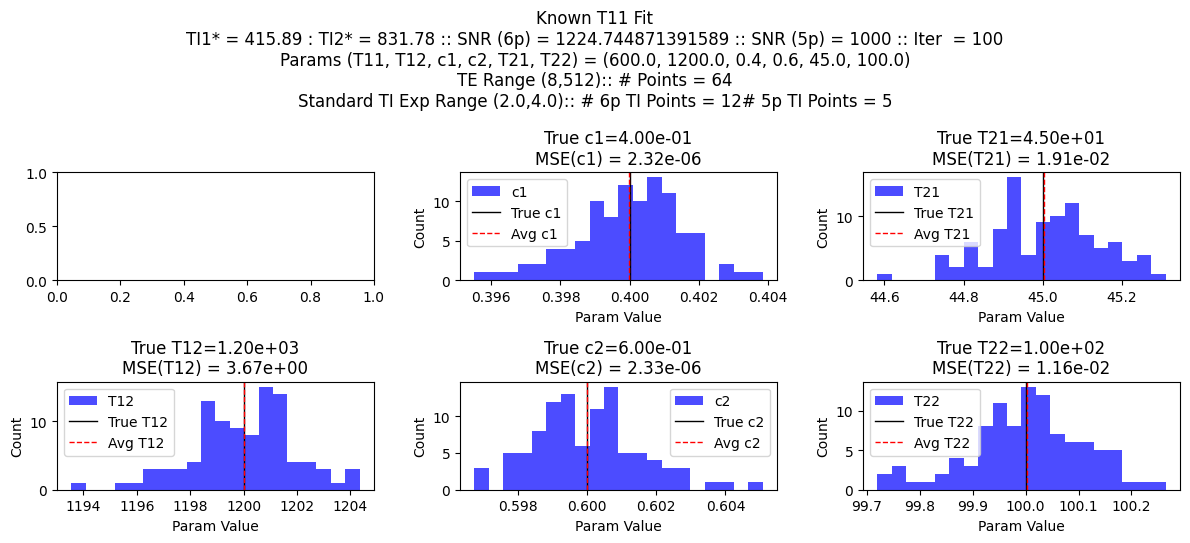

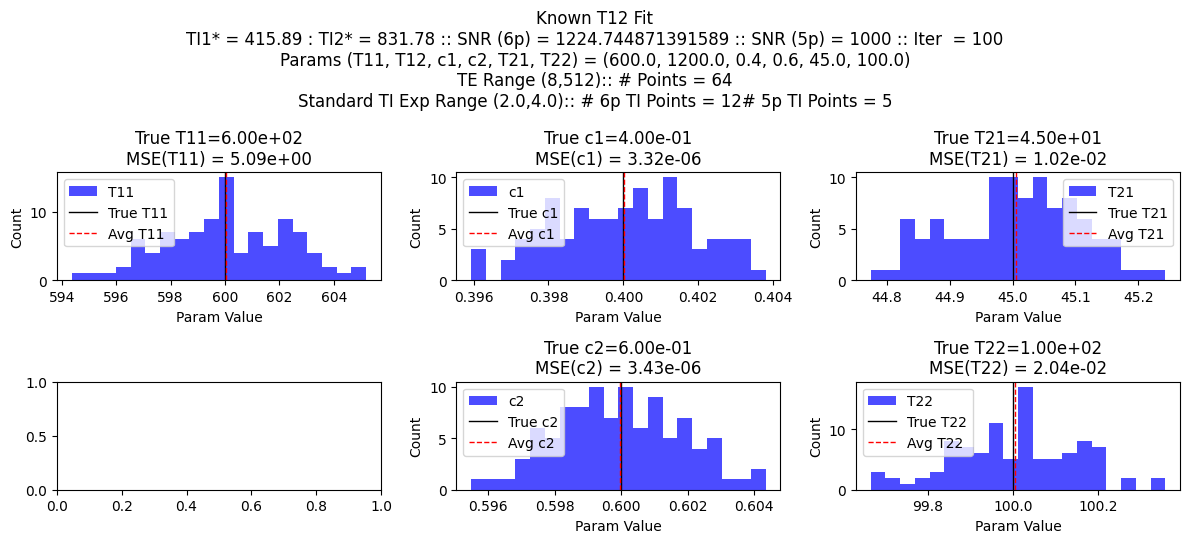

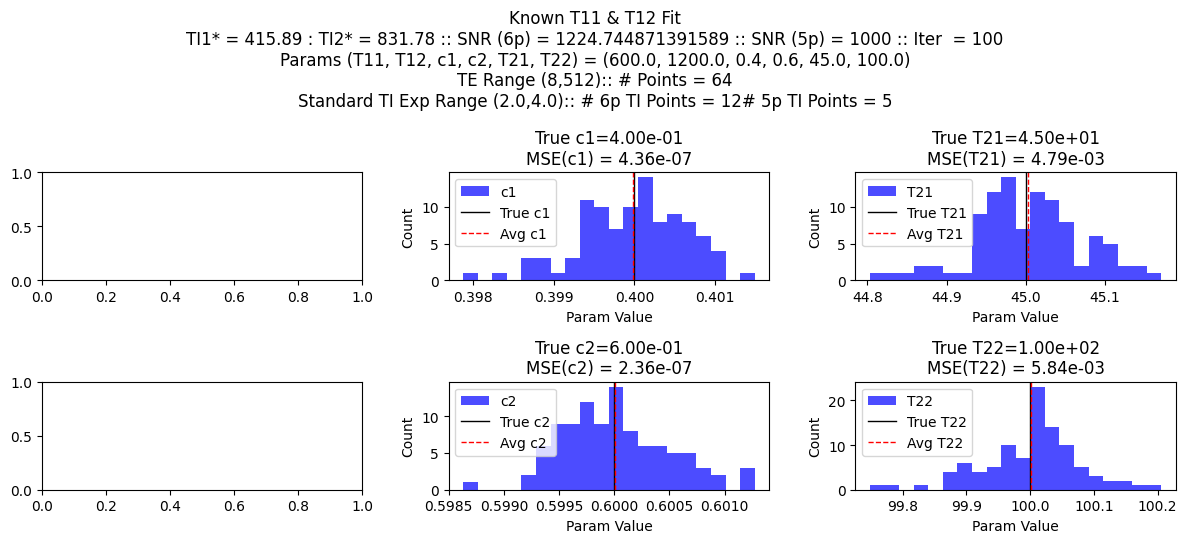

In [44]:
##### Plots Conventional Results
title_hold = "Conventional 6p Fit"
parameter_histogram(paramStore_6p_conven, initParams, paramTitle_6p, title_hold)

title_hold = "Known T11 Fit"
parameter_histogram(paramStore_T11_known, initParams[1:], paramTitle_6p[1:], title_hold)

title_hold = "Known T12 Fit"
parameter_histogram(paramStore_T12_known, [T11, c1, c2, T21, T22], ['T11','c1','c2','T21','T22'], title_hold)

title_hold = "Known T11 & T12 Fit"
parameter_histogram(paramStore_both_known, initParams[2:], paramTitle_6p[2:], title_hold)

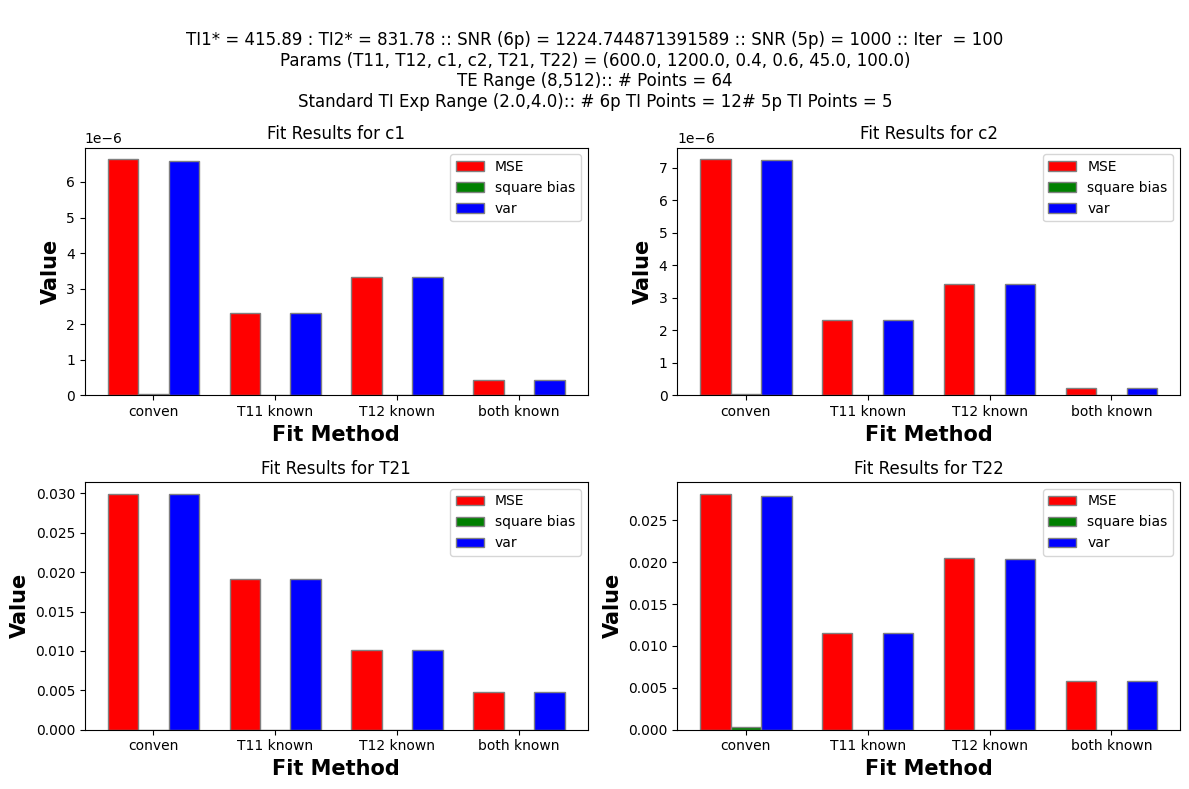

In [45]:
conven_MSE, conven_bias, conven_var = calc_MSE(paramStore_6p_conven, initParams, clipped = True)
T11_known_MSE, T11_known_bias, T11_known_var = calc_MSE(paramStore_T11_known, initParams[1:], clipped = True)
T12_known_MSE, T12_known_bias, T12_known_var = calc_MSE(paramStore_T12_known, [T11, c1, c2, T21, T22], clipped = True)
both_known_MSE, both_known_bias, both_known_var = calc_MSE(paramStore_both_known, initParams[2:], clipped = True)

MSE_complete = np.stack([conven_MSE, T11_known_MSE, T12_known_MSE, both_known_MSE])
bias_complete = np.stack([conven_bias, T11_known_bias, T12_known_bias, both_known_bias])
var_complete = np.stack([conven_var, T11_known_var, T12_known_var, both_known_var])

statistic_bars(MSE_complete, bias_complete, var_complete)


In [97]:
#Show that all the bias values are slightly different
display(T11_known_bias - T12_known_bias)

array([ 4.89432939e-11, -5.26297894e-11,  3.59080587e-09,  2.96743963e-09])

# Experimental Fitting Replication Subproject

### Generate Data

In [6]:
#Looping through iterations in building the parameter sets

for iter in trange(iterCount):
    
    #monoexponential method
    np_data = S_biX_6p(TE_array,TI1star,*initParams) #Generate the true nullpoint data
    np_noised = add_noise(SNR,np_data)

    np2_data = S_biX_6p(TE_array,TI2star,*initParams) #Generate the true nullpoint data
    np2_noised = add_noise(SNR,np2_data)

    mTE, mTI = np.meshgrid(TE_array,TI_array)
    mS = S_biX_6p(mTE,mTI,*initParams)
    mS_noised = add_noise(SNR,mS)

    vecT = np.vstack((mTE.ravel(), mTI.ravel())) #flattens the data points
    vecS = mS_noised.ravel()

    if nullMethod:
        null_mTE, null_mTI = np.meshgrid(TE_array,TI_nullArray)
        null_mS = S_biX_6p(null_mTE,null_mTI,*initParams)
        null_mS_noised = add_noise(SNR,null_mS)

        null_vecT = np.vstack((null_mTE.ravel(), null_mTI.ravel()))
        null_vecS = null_mS_noised.ravel()
    else:
        null_mTE = mTE
        null_mTI = mTI
        null_mS = mS
        null_mS_noised = mS_noised

        null_vecT = vecT
        null_vecS = vecS

    start = time.perf_counter()

    
    if unknownT12:
        init_p = [T12,c2,T22]
        lb = (1,-1,1)
        ub = (T1_bound,1,T2_bound)

        # popt_np1, pcov_np1 = curve_fit(lambda t_dat,est_c2,est_T22 : S_moX_2p(t_dat,est_c2,est_T22), TE_series, np_noised, p0 = init_p, bounds = [lb,ub]) 
        popt_np1, pcov_np1 = curve_fit(lambda t_dat,est_T12,est_c2,est_T22 : S_moX_3p(t_dat, TI1star, est_T12, est_c2, est_T22), 
                                            TE_array, np_noised, p0 = init_p, bounds = [lb,ub])
        p_T12, p_c2, p_T22 = popt_np1

        T12Store_np[iter] = p_T12

        init_p = [c1, T21] 
        lb = (-1,1)
        ub = (1,T2_bound)

        popt_np_All, pcov_np_All = curve_fit(lambda t_dat,est_c1,est_T21 : S_biX_6p_ravel(t_dat, T11, p_T12, est_c1, p_c2, est_T21, p_T22), 
                                                null_vecT, null_vecS, p0 = init_p, bounds = [lb,ub])
    else:
        init_p = [c2,T22]
        lb = (0,1)
        ub = (1,T2_bound)

        # popt_np1, pcov_np1 = curve_fit(lambda t_dat,est_c2,est_T22 : S_moX_2p(t_dat,est_c2,est_T22), TE_series, np_noised, p0 = init_p, bounds = [lb,ub]) 
        popt_np1, pcov_np1 = curve_fit(lambda t_dat,est_c2,est_T22 : S_moX_3p(t_dat, TI1star, T12, est_c2, est_T22),
                                         TE_array, np_noised, p0 = init_p, bounds = [lb,ub])
        p_c2, p_T22 = popt_np1


        init_p = [c1, T21]
        lb = (-1,1)
        ub = (1,T2_bound)

        popt_np_All, pcov_np_All = curve_fit(lambda t_dat,est_c1,est_T21 : S_biX_6p_ravel(t_dat, T11, T12, est_c1, p_c2, est_T21, p_T22),
                                                 null_vecT, null_vecS, p0 = init_p, bounds = [lb,ub])

    ttC_np = ttC_np + (time.perf_counter() - start)

    #Parameter fitting by only fitting using the nullpoints
    init_p = [c1,T21]
    popt_np2, pcov_np2 = curve_fit(lambda t_dat,est_c1,est_T21 : S_moX_3p(t_dat, TI2star, T11, est_c1, est_T21),
                                         TE_array, np2_noised, p0 = init_p, bounds = [lb,ub])
    p_c1, p_T21 = popt_np2

    #collecting all parameters estimated via the nullpoint method
    popt_np = (popt_np_All[-2], p_c2, popt_np_All[-1], p_T22)
    paramStore_np[iter,:] = popt_np

    paramStore_np2[iter,:] = (p_c1, p_c2, p_T21, p_T22)

    #6 parameter fit to the mesh
    start = time.perf_counter()

    init_p = [T11, T12, c1, c2, T21, T22]
    lb = (1,1,0,0,1,1)
    ub = (T1_bound,T1_bound,1,1,T2_bound,T2_bound)

    popt_6p, pcov_6p = curve_fit(lambda t_dat, e_T11, e_T12, e_c1, e_c2, e_T21, e_T22 : S_biX_6p_ravel(t_dat, e_T11, e_T12, e_c1, e_c2, e_T21, e_T22),
                                 vecT, vecS, p0 = init_p, bounds = [lb,ub])

    ttC_6p = ttC_6p + (time.perf_counter() - start)

    popt_6p = check_param_order(popt_6p)

    paramStore_6p[iter,:] = popt_6p

    #4 parameter fit to the mesh - knowing both nullpoints/T1 values
    start = time.perf_counter()

    init_p = [c1, c2, T21, T22]
    lb = (0,0,1,1)
    ub = (1,1,T2_bound,T2_bound)

    popt_4p, pcov_4p = curve_fit(lambda t_dat, e_c1, e_c2, e_T21, e_T22 : S_biX_6p_ravel(t_dat, T11, T12, e_c1, e_c2, e_T21, e_T22), 
                                    vecT, vecS, p0 = init_p, bounds = [lb,ub])

    ttC_4p = ttC_4p + (time.perf_counter() - start)

    popt_4p = check_param_order(popt_4p)

    paramStore_4p[iter,:] = popt_4p

    if unknownT12:
        est_Sig = S_biX_6p(null_mTE,null_mTI,T11,p_T12,*popt_np)
    else:
        est_Sig = S_biX_6p(null_mTE,null_mTI,T11,T12,*popt_np)
    RSS_np[iter] = np.sum((null_mS - est_Sig)**2)
    sigStore_np[iter,:,:] = est_Sig.T

    est_Sig = S_biX_6p(mTE,mTI,*popt_6p)
    RSS_6p[iter] = np.sum((mS - est_Sig)**2)
    sigStore_6p[iter,:,:] = est_Sig.T

    est_Sig = S_biX_6p(mTE,mTI, T11, T12, *popt_4p)
    RSS_4p[iter] = np.sum((mS - est_Sig)**2)
    sigStore_4p[iter,:,:] = est_Sig.T

100%|██████████| 10000/10000 [01:54<00:00, 87.11it/s]


### Plotting

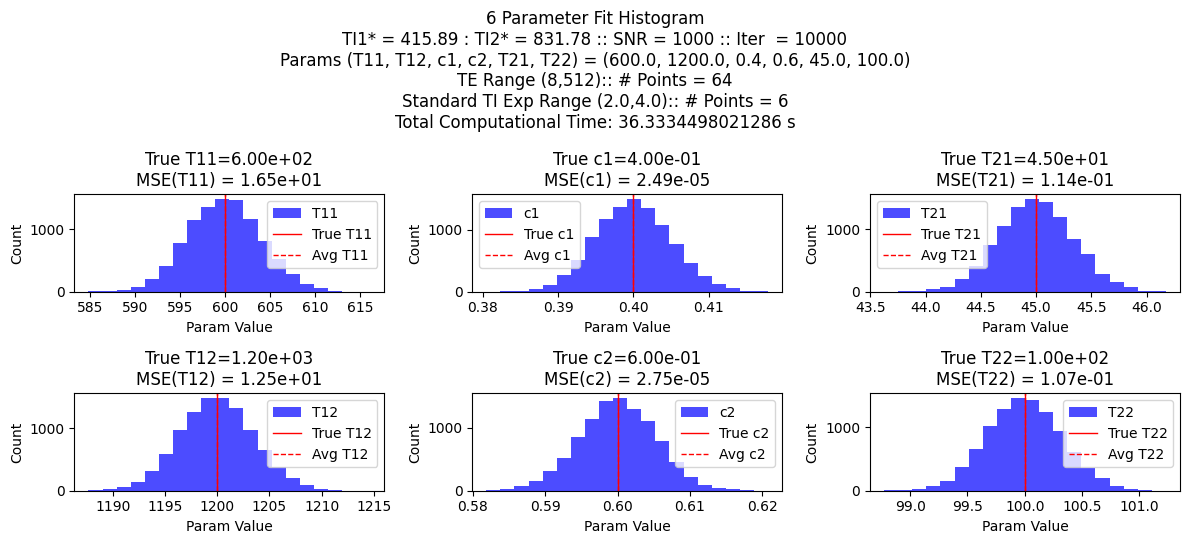

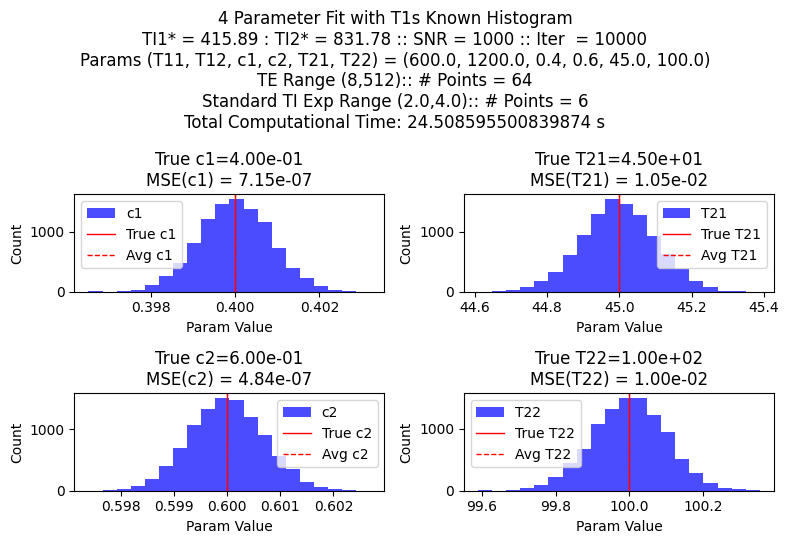

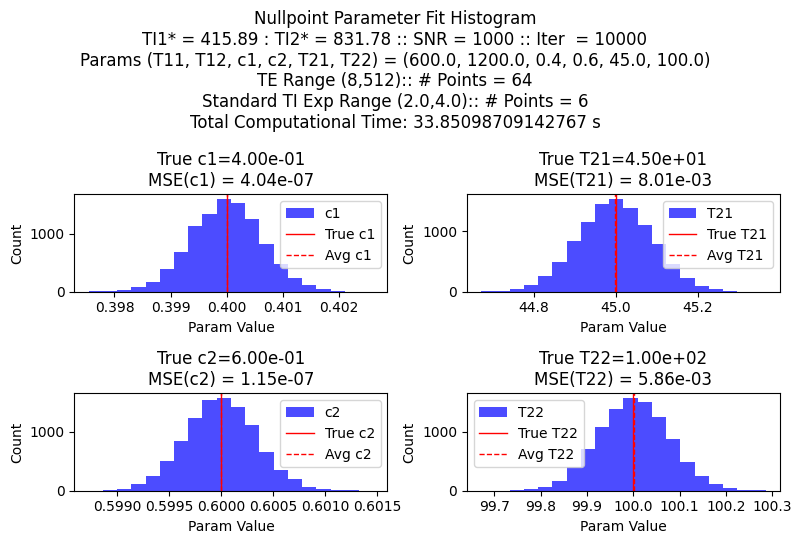

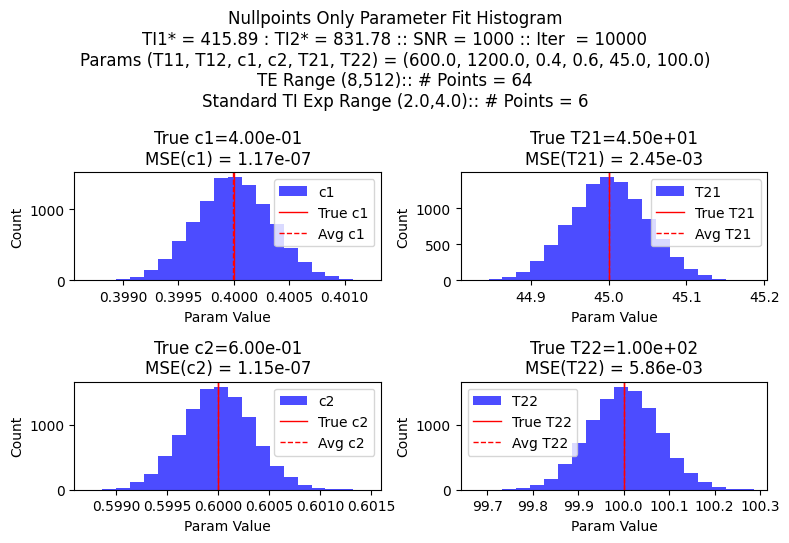

In [7]:
if histPlot:

    #########################################################################################################
    #Mesh fit without anything known
    fig, ax = plt.subplots(2,paramStore_6p.shape[1]//2, figsize=(12,5.5), tight_layout=True)
    fig.suptitle("6 Parameter Fit Histogram" + details + '\nTotal Computational Time: ' + str(ttC_6p) + ' s')

    varMat = np.var(paramStore_6p,axis=0)
    biMat = np.mean(paramStore_6p,axis=0) - initParams
    MSEMat = varMat + biMat**2
    
    for ii in range(paramStore_6p.shape[1]):
        #Construct a nice figure of each of the two 
        ax[ii%2,ii//2].hist(x=paramStore_6p[:,ii], bins=20, color='b', label = paramTitle_6p[ii], alpha = 0.7)
        # ax[ii].hist(x=paramStore_6p[:,2*ii+1], bins=20, color='g', label = paramTitle_6p[2*ii+1], alpha = 0.7)
        ax[ii%2,ii//2].set_xlabel('Param Value')
        ax[ii%2,ii//2].set_ylabel('Count')
        ax[ii%2,ii//2].axvline(x=initParams[ii], linewidth=1, label= 'True ' + paramTitle_6p[ii], color='red')
        # ax[ii%2,ii//2].axvline(x=initParams[ii+1], linewidth=1, label= 'True ' + paramTitle_6p[ii+1], color='orange')
        ax[ii%2,ii//2].axvline(x=np.mean(paramStore_6p[:,ii]), linewidth=1, label= 'Avg ' + paramTitle_6p[ii], color='red', ls = "--")
        # ax[ii].axvline(x=np.mean(paramStore_6p[:,2*ii+1]), linewidth=1, label= 'Avg ' + paramTitle_6p[2*ii+1], color='orange', ls = "--")
        ax[ii%2,ii//2].legend()
        ax[ii%2,ii//2].set_title('True ' + paramTitle_6p[ii] + '=' + "{:.2e}".format(initParams[ii]) + 
                    # '\nVar(' + paramTitle_6p[2*ii] + ') = ' +"{:.2e}".format(varMat[2*ii]) + 
                    # '\nBias(' + paramTitle_6p[2*ii] + ') = ' + "{:.2e}".format(biMat[2*ii]) + 
                    '\nMSE(' + paramTitle_6p[ii] + ') = ' + "{:.2e}".format(MSEMat[ii]))
    plt.show()


    ############################################################################################
    #Mesh Tactic when both nullpoints are known
    fig, ax = plt.subplots(2,paramStore_4p.shape[1]//2, figsize=(8,5.5), tight_layout=True)
    fig.suptitle("4 Parameter Fit with T1s Known Histogram" + details + '\nTotal Computational Time: ' + str(ttC_4p) + ' s')

    varMat = np.var(paramStore_4p,axis=0)
    biMat = np.mean(paramStore_4p,axis=0) - initParams[2:6]
    MSEMat = varMat + biMat**2
    
    for ii in range(paramStore_4p.shape[1]):
        #Construct a nice figure of each of the two 
        ax[ii%2,ii//2].hist(x=paramStore_4p[:,ii], bins=20, color='b', label = paramTitle_4p[ii], alpha = 0.7)
        # ax[ii].hist(x=paramStore_6p[:,2*ii+1], bins=20, color='g', label = paramTitle_6p[2*ii+1], alpha = 0.7)
        ax[ii%2,ii//2].set_xlabel('Param Value')
        ax[ii%2,ii//2].set_ylabel('Count')
        ax[ii%2,ii//2].axvline(x=initParams[ii+2], linewidth=1, label= 'True ' + paramTitle_4p[ii], color='red')
        # ax[ii%2,ii//2].axvline(x=initParams[ii+1], linewidth=1, label= 'True ' + paramTitle_6p[ii+1], color='orange')
        ax[ii%2,ii//2].axvline(x=np.mean(paramStore_4p[:,ii]), linewidth=1, label= 'Avg ' + paramTitle_4p[ii], color='red', ls = "--")
        # ax[ii].axvline(x=np.mean(paramStore_6p[:,2*ii+1]), linewidth=1, label= 'Avg ' + paramTitle_6p[2*ii+1], color='orange', ls = "--")
        ax[ii%2,ii//2].legend()
        ax[ii%2,ii//2].set_title('True ' + paramTitle_4p[ii] + '=' + "{:.2e}".format(initParams[ii+2]) + 
                    # '\nVar(' + paramTitle_6p[2*ii] + ') = ' +"{:.2e}".format(varMat[2*ii]) + 
                    # '\nBias(' + paramTitle_6p[2*ii] + ') = ' + "{:.2e}".format(biMat[2*ii]) + 
                    '\nMSE(' + paramTitle_4p[ii] + ') = ' + "{:.2e}".format(MSEMat[ii]))
    plt.show()

    

    #########################################################################################################
    #Figure for a mesh around a nullpoint - can be a single or two nullpoints known

    if unknownT12:
        shift = 1
        fig, ax = plt.subplots(2,paramStore_np.shape[1]//2+shift, figsize=(12,5.5), tight_layout=True)
    else:
        shift = 0
        fig, ax = plt.subplots(2,paramStore_np.shape[1]//2, figsize=(8,5.5), tight_layout=True)

    fig.suptitle("Nullpoint Parameter Fit Histogram" + details + '\nTotal Computational Time: ' + str(ttC_np) + ' s')

    varMat = np.var(paramStore_np,axis=0)
    biMat = np.mean(paramStore_np,axis=0) - initParams[2:6]
    MSEMat = varMat + biMat**2

    if unknownT12:
        varMat_T12 = np.var(T12Store_np,axis=0)
        biMat_T12 = np.mean(T12Store_np,axis=0) - initParams[1]
        MSEMat_T12 = varMat_T12 + biMat_T12**2

        ax[1,0].hist(x=T12Store_np[:], bins=20, color='b', label = paramTitle_6p[1], alpha = 0.7)
        ax[1,0].set_xlabel('Param Value')
        ax[1,0].set_ylabel('Count')
        ax[1,0].axvline(x=initParams[1], linewidth=1, label= 'True T12', color='red')
        ax[1,0].axvline(x=np.mean(T12Store_np[:]), linewidth=1, label= 'Avg T12', color='red', ls = "--")
        ax[1,0].legend()
        ax[1,0].set_title('True T12'  + '=' + "{:.2e}".format(T12) + ' :: '  
                    '\nMSE(T12) = ' + "{:.2e}".format(MSEMat_T12))
    
    for ii in range(paramStore_np.shape[1]):
        #Construct a nice figure of each of the two 
        ax[ii%2,ii//2+shift].hist(x=paramStore_np[:,ii], bins=20, color='b', label = paramTitle_np[ii], alpha = 0.7)
        # ax[ii].hist(x=paramStore_np[:,2*ii+1], bins=20, color='g', label = paramTitle_np[2*ii+1], alpha = 0.7)
        ax[ii%2,ii//2+shift].set_xlabel('Param Value')
        ax[ii%2,ii//2+shift].set_ylabel('Count')
        ax[ii%2,ii//2+shift].axvline(x=initParams[ii+2], linewidth=1, label= 'True ' + paramTitle_np[ii], color='red')
        # ax[ii].axvline(x=initParams[2*ii+3], linewidth=1, label= 'True ' + paramTitle_np[2*ii+1], color='orange')
        ax[ii%2,ii//2+shift].axvline(x=np.mean(paramStore_np[:,ii]), linewidth=1, label= 'Avg ' + paramTitle_np[ii], color='red', ls = "--")
        # ax[ii].axvline(x=np.mean(paramStore_np[:,2*ii+1]), linewidth=1, label= 'Avg ' + paramTitle_np[2*ii+1], color='orange', ls = "--")
        ax[ii%2,ii//2+shift].legend()
        ax[ii%2,ii//2+shift].set_title('True ' + paramTitle_np[ii] + '=' + "{:.2e}".format(initParams[ii+2]) +
                    # '\nVar(' + paramTitle_np[2*ii] + ') = ' "{:.2e}".format(varMat[2*ii],2) + 
                    # '\nBias(' + paramTitle_np[2*ii] + ') = ' + "{:.2e}".format(biMat[2*ii]) + 
                    '\nMSE(' + paramTitle_np[ii] + ') = ' + "{:.2e}".format(MSEMat[ii]))
    plt.show()


    #########################################################################################################
    #Figure when both nullpoints are known and the decay curves are taken from the nullpoints
    fig, ax = plt.subplots(2,paramStore_np.shape[1]//2, figsize=(8,5.5), tight_layout=True)

    fig.suptitle("Nullpoints Only Parameter Fit Histogram" + details)

    varMat = np.var(paramStore_np2,axis=0)
    biMat = np.mean(paramStore_np2,axis=0) - initParams[2:6]
    MSEMat = varMat + biMat**2
    
    for ii in range(paramStore_np.shape[1]):
        #Construct a nice figure of each of the two 
        ax[ii%2,ii//2].hist(x=paramStore_np2[:,ii], bins=20, color='b', label = paramTitle_np[ii], alpha = 0.7)
        # ax[ii].hist(x=paramStore_np[:,2*ii+1], bins=20, color='g', label = paramTitle_np[2*ii+1], alpha = 0.7)
        ax[ii%2,ii//2].set_xlabel('Param Value')
        ax[ii%2,ii//2].set_ylabel('Count')
        ax[ii%2,ii//2].axvline(x=initParams[ii+2], linewidth=1, label= 'True ' + paramTitle_np[ii], color='red')
        # ax[ii].axvline(x=initParams[2*ii+3], linewidth=1, label= 'True ' + paramTitle_np[2*ii+1], color='orange')
        ax[ii%2,ii//2].axvline(x=np.mean(paramStore_np2[:,ii]), linewidth=1, label= 'Avg ' + paramTitle_np[ii], color='red', ls = "--")
        # ax[ii].axvline(x=np.mean(paramStore_np[:,2*ii+1]), linewidth=1, label= 'Avg ' + paramTitle_np[2*ii+1], color='orange', ls = "--")
        ax[ii%2,ii//2].legend()
        ax[ii%2,ii//2].set_title('True ' + paramTitle_np[ii] + '=' + "{:.2e}".format(initParams[ii+2]) +
                    # '\nVar(' + paramTitle_np[2*ii] + ') = ' "{:.2e}".format(varMat[2*ii],2) + 
                    # '\nBias(' + paramTitle_np[2*ii] + ') = ' + "{:.2e}".format(biMat[2*ii]) + 
                    '\nMSE(' + paramTitle_np[ii] + ') = ' + "{:.2e}".format(MSEMat[ii]))
    plt.show()

##### Ratio of SD for Parameters

In [8]:
stdMat_6p = np.std(paramStore_6p,axis=0)
stdMat_np = np.std(paramStore_np,axis=0)

for s in range(np.size(paramTitle_6p)):
    if s>1:
        param_ratio = stdMat_6p[s]/stdMat_np[s-2]
        print("Ratio of " + paramTitle_6p[s] + " std --> 6p : nullpoint :: " + str(round(param_ratio,2)) + " : 1 | Order " + str(np.round(np.log10(stdMat_np[s-2]),2)))
    elif s==1 and unknownT12:
        param_ratio = stdMat_6p[s]/np.std(T12Store_np)
        print("Ratio of " + paramTitle_6p[s] + " std --> 6p : nullpoint :: " + str(round(param_ratio,2)) + " : 1 | Order " + str(np.round(np.log10(np.std(T12Store_np)),2)))
    else:
        print("Ratio of " + paramTitle_6p[s] + " std is not possible since the nullpoint fit doesn't solve for " + paramTitle_6p[s])

Ratio of T11 std is not possible since the nullpoint fit doesn't solve for T11
Ratio of T12 std is not possible since the nullpoint fit doesn't solve for T12
Ratio of c1 std --> 6p : nullpoint :: 7.85 : 1 | Order -3.2
Ratio of c2 std --> 6p : nullpoint :: 15.46 : 1 | Order -3.47
Ratio of T21 std --> 6p : nullpoint :: 3.77 : 1 | Order -1.05
Ratio of T22 std --> 6p : nullpoint :: 4.26 : 1 | Order -1.12


In [9]:
biMat_6p = np.mean(paramStore_6p,axis=0) - initParams
biMat_np = np.mean(paramStore_np,axis=0) - initParams[2:6]

for s in range(np.size(paramTitle_6p)):
    if s>1:
        param_ratio = biMat_6p[s]/biMat_np[s-2]
        print("Ratio of " + paramTitle_6p[s] + " bias --> 6p : nullpoint :: " + str(round(param_ratio,2)) + " : 1 | Order " + str(np.round(np.log10(np.abs(biMat_np[s-2])),2)))
    elif s==1 and unknownT12:
        param_ratio = stdMat_6p[s]/(np.mean(T12Store_np) - initParams[1])
        print("Ratio of " + paramTitle_6p[s] + " bias --> 6p : nullpoint :: " + str(round(param_ratio,2)) + " : 1 | Order " + str(np.round(np.log10((np.mean(T12Store_np) - initParams[1])),2)))
    else:
        print("Ratio of " + paramTitle_6p[s] + " bias is not possible since the nullpoint fit doesn't solve for " + paramTitle_6p[s])

Ratio of T11 bias is not possible since the nullpoint fit doesn't solve for T11
Ratio of T12 bias is not possible since the nullpoint fit doesn't solve for T12
Ratio of c1 bias --> 6p : nullpoint :: 21.25 : 1 | Order -5.99
Ratio of c2 bias --> 6p : nullpoint :: -31.91 : 1 | Order -6.13
Ratio of T21 bias --> 6p : nullpoint :: 3.93 : 1 | Order -2.94
Ratio of T22 bias --> 6p : nullpoint :: -0.16 : 1 | Order -3.16


In [9]:
MSEMat_6p = stdMat_6p**2 + biMat_6p**2
MSEMat_np = stdMat_np**2 + biMat_np**2

for s in range(np.size(paramTitle_6p)):
    if s>1:
        param_ratio = MSEMat_6p[s]/MSEMat_np[s-2]
        print("Ratio of " + paramTitle_6p[s] + " MSE --> 6p : nullpoint :: " + str(round(param_ratio,2)) + " : 1 | Order " + str(np.round(np.log10(MSEMat_np[s-2]),2)))
    elif s==1 and unknownT12:
        MSE_T12 = np.std(T12Store_np)**2 + (np.mean(T12Store_np) - initParams[1])**2 
        param_ratio = stdMat_6p[s]/MSE_T12
        print("Ratio of " + paramTitle_6p[s] + " bias --> 6p : nullpoint :: " + str(round(param_ratio,2)) + " : 1 | Order " + str(np.round(np.log10(MSE_T12),2)))
    else:
        print("Ratio of " + paramTitle_6p[s] + " MSE is not possible since the nullpoint fit doesn't solve for " + paramTitle_6p[s])

Ratio of T11 MSE is not possible since the nullpoint fit doesn't solve for T11
Ratio of T12 MSE is not possible since the nullpoint fit doesn't solve for T12
Ratio of c1 MSE --> 6p : nullpoint :: 61.36 : 1 | Order -6.39
Ratio of c2 MSE --> 6p : nullpoint :: 239.23 : 1 | Order -6.94
Ratio of T21 MSE --> 6p : nullpoint :: 14.19 : 1 | Order -2.1
Ratio of T22 MSE --> 6p : nullpoint :: 18.11 : 1 | Order -2.23


In [10]:
stdMat_np2 = np.std(paramStore_np2,axis=0)
biMat_np2 = np.mean(paramStore_np2,axis=0) - initParams[2:6]
MSEMat_np2 = stdMat_np2**2 + biMat_np2**2

for s in range(2):
    param_ratio = stdMat_np2[2*s]/stdMat_np[2*s]
    print("Ratio of " + paramTitle_6p[2*s+2] + " std --> 2 nullpoints : nullpoint :: " + str(round(param_ratio,2)) + " : 1 | Order " + str(np.round(np.log10(np.abs(biMat_np[s-2])),2)))
    param_ratio = biMat_np2[2*s]/biMat_np[2*s]
    print("Ratio of " + paramTitle_6p[2*s+2] + " bias --> 2 nullpoints : nullpoint :: " + str(round(param_ratio,2)) + " : 1 | Order " + str(np.round(np.log10(np.abs(biMat_np[s-2])),2)))
    param_ratio = MSEMat_np2[2*s]/MSEMat_np[2*s]
    print("Ratio of " + paramTitle_6p[2*s+2] + " MSE --> 2 nullpoints : nullpoint :: " + str(round(param_ratio,2)) + " : 1 | Order " + str(np.round(np.log10(np.abs(biMat_np[s-2])),2)))    

Ratio of c1 std --> 2 nullpoints : nullpoint :: 0.53 : 1 | Order -2.79
Ratio of c1 bias --> 2 nullpoints : nullpoint :: -0.79 : 1 | Order -2.79
Ratio of c1 MSE --> 2 nullpoints : nullpoint :: 0.28 : 1 | Order -2.79
Ratio of T21 std --> 2 nullpoints : nullpoint :: 0.55 : 1 | Order -2.8
Ratio of T21 bias --> 2 nullpoints : nullpoint :: -0.55 : 1 | Order -2.8
Ratio of T21 MSE --> 2 nullpoints : nullpoint :: 0.3 : 1 | Order -2.8


In [12]:
stdMat_4p = np.std(paramStore_4p,axis=0)
biMat_4p = np.mean(paramStore_4p,axis=0) - initParams[2:6]
MSEMat_4p = stdMat_4p**2 + biMat_4p**2

for s in range(4):
    param_ratio = stdMat_4p[s]/stdMat_np[s]
    print("Ratio of " + paramTitle_4p[s] + " std --> 2 nullpoints : nullpoint :: " + str(round(param_ratio,2)) + " : 1 | Order " + str(np.round(np.log10(np.abs(biMat_np[s])),2)))
    param_ratio = biMat_4p[s]/biMat_np[s]
    print("Ratio of " + paramTitle_4p[s] + " bias --> 2 nullpoints : nullpoint :: " + str(round(param_ratio,2)) + " : 1 | Order " + str(np.round(np.log10(np.abs(biMat_np[s])),2)))
    param_ratio = MSEMat_4p[s]/MSEMat_np[s]
    print("Ratio of " + paramTitle_4p[s] + " MSE --> 2 nullpoints : nullpoint :: " + str(round(param_ratio,2)) + " : 1 | Order " + str(np.round(np.log10(np.abs(biMat_np[s])),2)))    

Ratio of c1 std --> 2 nullpoints : nullpoint :: 1.33 : 1 | Order -5.31
Ratio of c1 bias --> 2 nullpoints : nullpoint :: -0.02 : 1 | Order -5.31
Ratio of c1 MSE --> 2 nullpoints : nullpoint :: 1.78 : 1 | Order -5.31
Ratio of c2 std --> 2 nullpoints : nullpoint :: 2.06 : 1 | Order -5.26
Ratio of c2 bias --> 2 nullpoints : nullpoint :: 0.95 : 1 | Order -5.26
Ratio of c2 MSE --> 2 nullpoints : nullpoint :: 4.25 : 1 | Order -5.26
Ratio of T21 std --> 2 nullpoints : nullpoint :: 1.14 : 1 | Order -2.79
Ratio of T21 bias --> 2 nullpoints : nullpoint :: -0.07 : 1 | Order -2.79
Ratio of T21 MSE --> 2 nullpoints : nullpoint :: 1.29 : 1 | Order -2.79
Ratio of T22 std --> 2 nullpoints : nullpoint :: 1.31 : 1 | Order -2.8
Ratio of T22 bias --> 2 nullpoints : nullpoint :: -0.13 : 1 | Order -2.8
Ratio of T22 MSE --> 2 nullpoints : nullpoint :: 1.72 : 1 | Order -2.8
